In [1]:
from pyTigerGraph import TigerGraphConnection
   
conn = TigerGraphConnection(
    host="http://TIGERGRAPH_DB_ADDRESS",
    username="YOUR_USERNAME",
    password="YOUR_PASSWORD",
    graphname="Transaction_Fraud"
)

In [36]:
frauds = conn.getVertexCount("Payment_Transaction", where="is_fraud = 1") 
nonfrauds = conn.getVertexCount("Payment_Transaction", where="is_fraud = 0") 
print("Fraud transactions: {} ({:.2f}%)".format(frauds, frauds/(frauds+nonfrauds)*100))
print("Normal transactions: {} ({:.2f}%)".format(nonfrauds, nonfrauds/(frauds+nonfrauds)*100))

Fraud transactions: 2201 (1.05%)
Normal transactions: 208388 (98.95%)


In [45]:
features = [
    "mer_com_size", "cd_com_size", "mer_pagerank", "cd_pagerank", "shortest_path_length",
    "max_txn_amt_interval", "max_txn_cnt_interval", "cnt_repeated_card", "com_mer_txn_cnt", "com_cd_txn_cnt",
    "com_mer_txn_total_amt", "com_cd_txn_total_amt", "com_mer_txn_avg_amt", "com_cd_txn_avg_amt",
    "com_mer_txn_max_amt", "com_cd_txn_max_amt", "com_mer_txn_min_amt", "com_cd_txn_min_amt",
    "mer_cat_cnt", "mer_cat_total_amt", "mer_cat_avg_amt", "mer_cat_max_amt", "mer_cat_min_amt",
    "indegree", "outdegree"
]

labels = ["is_fraud"]

others = ["transaction_time"]

In [46]:
transactions = conn.getVertexDataFrame(
    "Payment_Transaction", 
    select=",".join(features+labels+others))

In [47]:
transactions["transaction_time"] = pd.to_datetime(transactions["transaction_time"])

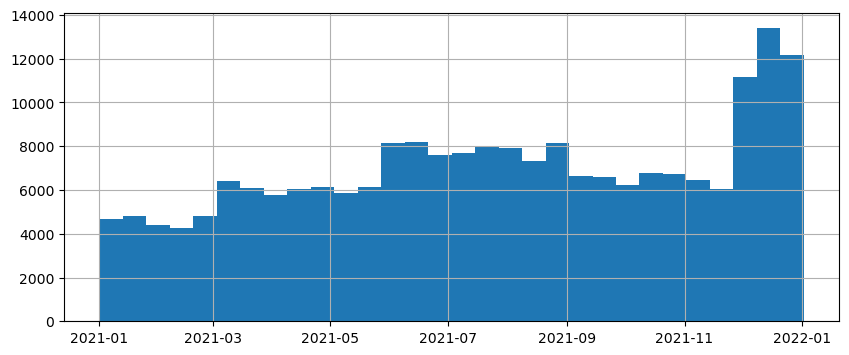

In [49]:
transactions.transaction_time.hist(bins=30, figsize=(10,4));

In [55]:
train_data = transactions[transactions.transaction_time<"2021-11-01"]
test_data = transactions[transactions.transaction_time>="2021-11-01"]

In [56]:
tmp = train_data.groupby("is_fraud").size()
print("Fraud transactions in training set: {} ({:.2f}%%)".format(tmp[1], tmp[1]/tmp.sum()*100))
print("Normal transactions in training set: {} ({:.2f}%%)".format(tmp[0], tmp[0]/tmp.sum()*100))

Fraud transactions in training set: 1947 (1.21%%)
Normal transactions in training set: 159099 (98.79%%)


In [57]:
tmp = test_data.groupby("is_fraud").size()
print("Fraud transactions in test set: {} ({:.2f}%%)".format(tmp[1], tmp[1]/tmp.sum()*100))
print("Normal transactions in test set: {} ({:.2f}%%)".format(tmp[0], tmp[0]/tmp.sum()*100))

Fraud transactions in test set: 254 (0.51%%)
Normal transactions in test set: 49289 (99.49%%)


In [81]:
from xgboost import XGBClassifier, plot_importance

tree_model = XGBClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1, 
    objective='binary:logistic', max_depth=2, scale_pos_weight=1, 
    min_child_weight=80, gamma = 10, max_delta_step=2) 

In [82]:
tree_model.fit(train_data[features], train_data["is_fraud"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=10, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=2, max_leaves=0, min_child_weight=80, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, predictor='auto', ...)

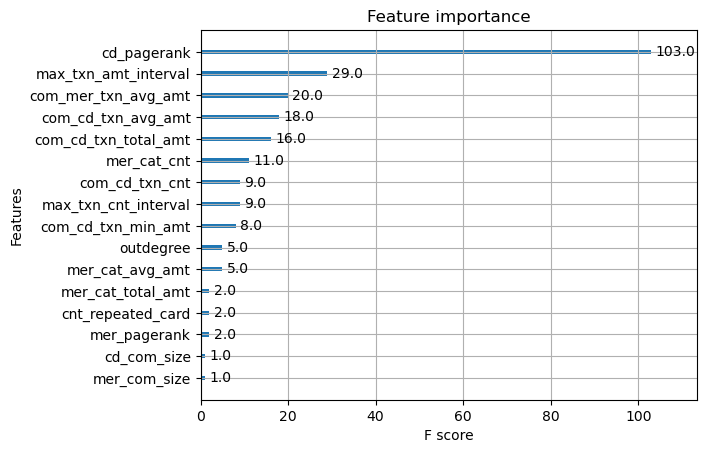

In [83]:
plot_importance(tree_model);

In [84]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

def test(model, X, y):
    predictions = tree_model.predict(X)
    probabilities = tree_model.predict_proba(X)[:,1]
    print(classification_report(y, predictions))
    ConfusionMatrixDisplay.from_predictions(y, predictions);
    PrecisionRecallDisplay.from_predictions(y, probabilities);

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     49289
           1       0.00      0.00      0.00       254

    accuracy                           0.99     49543
   macro avg       0.50      0.50      0.50     49543
weighted avg       0.99      0.99      0.99     49543



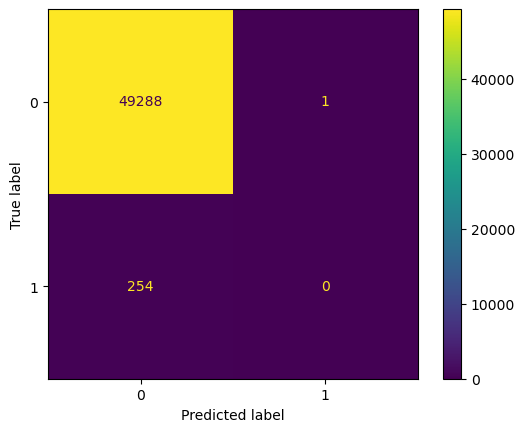

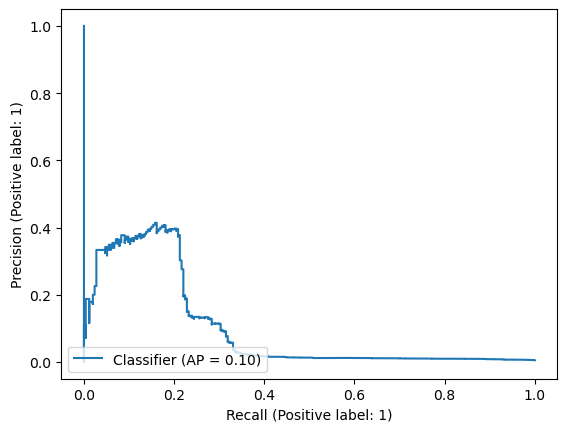

In [85]:
test(tree_model, test_data[features], test_data["is_fraud"])

In [73]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

def tune(model, X, y, param_grid, metric="f1", verbose=2):
    gsearch = GridSearchCV(model, return_train_score=True, param_grid=param_grid, 
                           scoring=metric, n_jobs=1, cv=5, verbose=verbose)
    gsearch.fit(X,y)
    s1 = gsearch.cv_results_["mean_train_score"]
    s2 = gsearch.cv_results_["mean_test_score"]
    plt.plot(s1, s2, "o")
    x0 = min(s1.min(), s2.min())
    x1 = max(s1.max(), s2.max())
    plt.plot([x0, x1], [x0, x1], color="grey")
    plt.xlabel("Train Score")
    plt.ylabel("Test Score")
    print("Best parameters:", gsearch.best_params_)
    model.set_params(**gsearch.best_params_)

In [74]:
param_grid = {
    "n_estimators": range(1, 100, 10),
    "scale_pos_weight": range(1, 100, 10)
}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 91, 'scale_pos_weight': 11}


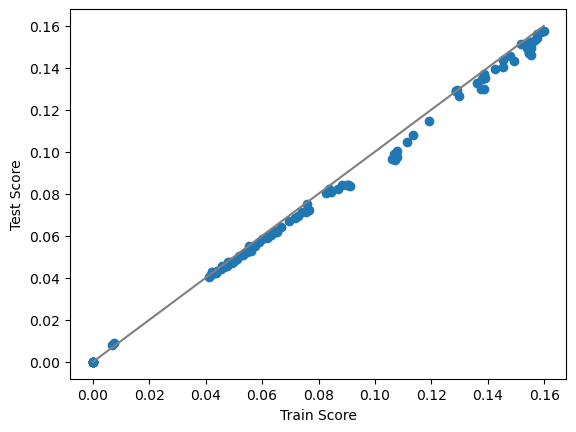

In [75]:
tune(tree_model, train_data[features], train_data["is_fraud"], param_grid, verbose=1)

              precision    recall  f1-score   support

           0       1.00      0.02      0.04     49289
           1       0.01      0.99      0.01       254

    accuracy                           0.03     49543
   macro avg       0.50      0.51      0.03     49543
weighted avg       0.99      0.03      0.04     49543



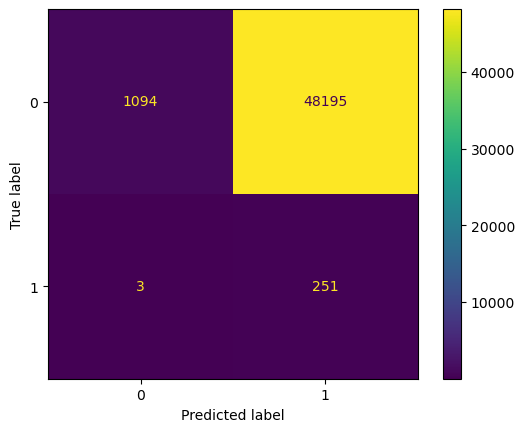

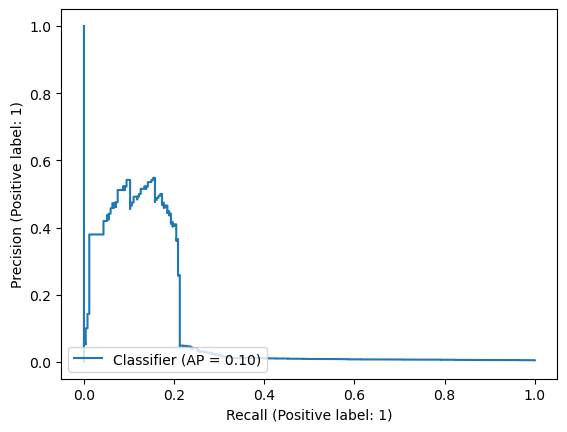

In [78]:
test(tree_model, test_data[features], test_data["is_fraud"])